## Import Dependencies

In [1]:
from gym.wrappers import FrameStack
from Preprocessing import *
from Agents import *

## Create Gym Environment

In [2]:
env = gym.make('SpaceInvaders-v0')
height, width, channel = env.observation_space.shape
actions = env.action_space.n

In [3]:
actions

6

In [4]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [5]:
env.observation_space.shape

(210, 160, 3)

## Random play (This will crash the kernel if in render_mode='human')
@OpenAi pls fix

In [6]:
episodes = 3

for episode in range(episodes):
    state = env.reset()
    done = False
    score = 0

    while not done:
        #env.render()
        action = random.choice(range(6))
        n_state,reward,done,info = env.step(action)
        score+=reward

    print("Episode:{}   Score:{}".format(episode,score))
env.close()

Episode:0   Score:180.0
Episode:1   Score:55.0
Episode:2   Score:270.0


## Apply Transformations to the Environment

In [7]:
# Apply Wrappers to environment
frame_lag = 4 #We won't record every frame to save on resources
env_2 = SkipFrame(env, skip=frame_lag) #Game is repetitive. Only analyze every 4th frame
env_2 = GrayScaleObservation(env) #Graysacale conversion
env_2 = ResizeObservation(env_2, shape=84) #Make it a smaller square
env_2 = FrameStack(env_2,num_stack=frame_lag) #Stack the last 4 frames into one observation (the ones we skipped)

In [8]:
env_2.observation_space.shape

(4, 84, 84)

## Train the model

In [9]:
from pathlib import Path
from collections import deque

### Initialize the look-up table

In [10]:
look_up_table = np.zeros(shape=(0,actions))

### Train and report the results

In [1]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

look_up_table = np.zeros(shape=(0,actions)) # Initialize the look-up table

save_dir = Path("checkpoints_space-invaders") / "1000_model_or_min_first"
save_dir.mkdir(parents=True)

ship = Ship(state_dim=(4, 84, 84),
            action_dim=env_2.action_space.n,
            save_dir=save_dir,
            exploration_rate_decay=0.9999975,
            exploration_rate_min=0.1,
            batch_size=48,
            gamma=0.93,
            lr=0.009,
            learn_every=4,
            sync_every=5000
            )

episodes = 1000
e=1
loop_condition = True
episode_reward = deque(maxlen=20)

while loop_condition:
    memory_usage = torch.cuda.memory_reserved(0)/6e9
    look_up_table = np.zeros(shape=(0,actions)) #Reset the value of the look-up table
    state = env_2.reset()

    sum_reward = 0
    number_of_states = 1
    # Play the game!
    while True:

        # Run agent on the state
        action,action_values = ship.act(state)

        # Agent performs action
        next_state, reward, done, info = env_2.step(action)

        # Remember
        ship.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = ship.learn()

        # Append q values to look-up table
        look_up_table = np.append(look_up_table,action_values,axis=0)
        sum_reward+=reward

        # Update state
        state = next_state

        # Check if end of game
        if done:
            break

    episode_reward.append(sum_reward)
    if e % 10 == 0:
        print(f"Episode:    {e}")
        print(f"% of CUDA memory used:  {memory_usage*100}%\n"
              f"    Epsilon:    {ship.exploration_rate}\n"
              f"    Rolling avg. 20 reward:     {sum(episode_reward)/len(episode_reward)}\n"
              f"    Step:   {ship.curr_step}\n"
              f"    Q value:    {ship.Q}\n"
              f"    Loss:   {ship.loss}\n"
              f"    Look-up table:")
        print(look_up_table)
    e+=1

    if e>episodes or ship.exploration_rate<=ship.exploration_rate_min:
        loop_condition=False
        print(f"Training finished at {e-1} episodes!\n"
              f"    Final epsilon:  {ship.exploration_rate}\n"
              f"    Final Rolling avg. 20 reward:   {sum(episode_reward)/len(episode_reward)}\n"
              f"    Final look-up table")
        print(look_up_table)


NameError: name 'torch' is not defined

### Visualize the Look-up table on a heatmap

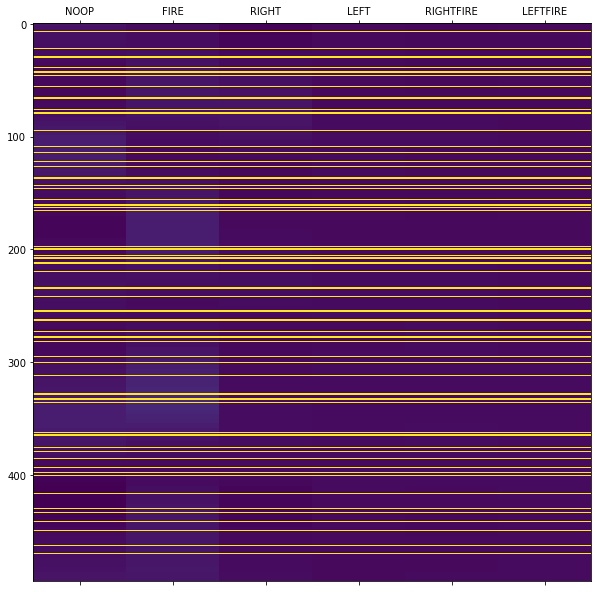

In [16]:
import matplotlib.pyplot as plt

labels = env.unwrapped.get_action_meanings()

plt.figure(figsize=(10,10))
plt.matshow(look_up_table, fignum=1, aspect='auto')
plt.xticks(ticks=range(actions),labels=labels,rotation ='horizontal')

plt.show()

### Save the model to a chkpt file

In [17]:
best_model_path = ship.save()

Agent saved to checkpoints_space-invaders\100_model\space-invaders_net_77748.chkpt at step 77748


## Play the game (This will crash the kernel)
@OpenAi pls fix

In [18]:
#ship = Ship(state_dim=(4, 84, 84), action_dim=env_2.action_space.n, save_dir=save_dir)
#ship.load('checkpoints_space-invaders/best_model/space-invaders_net_860474.chkpt')
back = ship.exploration_rate
env_3 = gym.make('SpaceInvaders-v0',render_mode='human')
env_3 = SkipFrame(env_3, skip=4)
env_3 = GrayScaleObservation(env_3)
env_3 = ResizeObservation(env_3, shape=84)
env_3 = FrameStack(env_3, num_stack=4)

reward_list=[]
for e in range(1,4):

    state = env_3.reset()
    episode_reward=0
    # Play the game!
    while True:

        # Run agent on the state
        action,_ = ship.act(state)

        # Agent performs action
        next_state, reward, done, info = env_3.step(action)
        episode_reward+=reward

        if done:
            reward_list.append(episode_reward)
            break
    print(
        f"Episode:  {e}\n"
        f"     Episode Reward:     {episode_reward}\n"
        f"     Average Reward:     {sum(reward_list)/len(reward_list)}")
env_3.close()

Episode:  1
     Episode Reward:     180.0
     Average Reward:     180.0
Episode:  2
     Episode Reward:     390.0
     Average Reward:     285.0
Episode:  3
     Episode Reward:     135.0
     Average Reward:     235.0


## Optuna Optimizazion

In [9]:
from tqdm.notebook import tnrange, tqdm
import optuna
from optuna.trial import TrialState

class Optimizer:
    def __init__(self):
        self.agent = None
        self.avg_reward = 0

    def define_model(self,trial):
        exploration_rate_decay = trial.suggest_categorical("exploration_rate_decay",[0.99999975,0.9999975,0.999975])
        exploration_rate_min = trial.suggest_float("exploration_rate_min",0.05,0.2,step=0.05)
        batch_size = trial.suggest_int("batch_size",8,64,step=8)
        gamma = trial.suggest_float("gamma",0.9,0.99,step=0.01)
        lr = trial.suggest_float("lr",0.0001,0.001,step=0.0001)
        learn_every = trial.suggest_int('learn_every',1,5)
        sync_every = trial.suggest_int('sync_every',5000,20000,step=5000)

        return Ship(state_dim=(4, 84, 84),
                    action_dim=env_2.action_space.n,
                    save_dir=save_dir,
                    exploration_rate_decay=exploration_rate_decay,
                    exploration_rate_min=exploration_rate_min,
                    batch_size= batch_size,
                    gamma = gamma,
                    lr = lr,
                    learn_every=learn_every,
                    sync_every = sync_every)

    def objective(self,trial):
        agent = self.define_model(trial)
        avg_reward = 0
        status = 'Current Params:\n'
        #print('Current Params:',end='\r')
        for key, value in trial.params.items():
            status+="    {}: {}".format(key, value) + '\n'
            #print("    {}: {}".format(key, value),end='\r')
        print(status)

        episodes = 1000
        e=1
        loop_condition = True
        episode_reward = deque(maxlen=20)

        while loop_condition:
            memory_usage = torch.cuda.memory_reserved(0)/6e9
            look_up_table = np.zeros(shape=(0,actions))
            state = env_2.reset()

            sum_reward = 0
            # Play the game!
            while True:

                # Run agent on the state
                action,action_values = agent.act(state)

                # Agent performs action
                next_state, reward, done, info = env_2.step(action)

                # Remember
                agent.cache(state, next_state, action, reward, done)

                # Learn
                q, loss = agent.learn()
                look_up_table = np.append(look_up_table,action_values,axis=0)
                sum_reward+=reward

                # Logging
                #logger.log_step(reward, loss, q)

                # Update state
                state = next_state

                # Check if end of game
                if done:
                    break

            #logger.log_episode()
            episode_reward.append(sum_reward)
            avg_reward = sum(episode_reward)/len(episode_reward)
            if e % 10 == 0:
                #logger.record(episode=e, epsilon=ship.exploration_rate, step=ship.curr_step,write=True)
                print(f"Episode:    {e}")
                print(f"% of CUDA memory used:  {memory_usage*100}%\n"
                      f"    Epsilon:    {agent.exploration_rate}\n"
                      f"    Rolling avg. 20 reward:     {avg_reward}\n"
                      f"    Step:   {agent.curr_step}\n"
                      f"    Q value:    {agent.Q}\n"
                      f"    Loss:   {agent.loss}\n"
                      f"    Look-up table:")
                print(look_up_table)
            trial.report(avg_reward,e)


            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            e+=1
            if e>episodes:
                loop_condition=False
                print(f"Training finished at {e-1} episodes!\n"
                      f"    Final epsilon:  {agent.exploration_rate}\n"
                      f"    Final Rolling avg. 20 reward:   {avg_reward}\n"
                      f"    Final look-up table")
                print(look_up_table)


        if avg_reward > self.avg_reward:
            self.avg_reward = avg_reward
            self.agent = agent
        return avg_reward

In [10]:
evaluator = Optimizer()

study = optuna.create_study(direction='maximize')
study.optimize(evaluator.objective,n_trials=10,show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-06-07 02:20:30,607] A new study created in memory with name: no-name-98016654-ca81-4b7f-ba67-b4d695763c4b
C:\ProgramData\Anaconda3\envs\robo_shakespeare\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

Current Params:
    exploration_rate_decay: 0.9999975
    exploration_rate_min: 0.2
    batch_size: 64
    gamma: 0.93
    lr: 0.0008
    learn_every: 2
    sync_every: 10000

Episode:    10
% of CUDA memory used:  4.264209066666667%
    Epsilon:    0.9840608739387163
    Rolling avg. 20 reward:     108.5
    Step:   6427
    Q value:    None
    Loss:   0
    Look-up table:
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
Episode:    20
% of CUDA memory used:  5.382690133333334%
    Epsilon:    0.9669243269768778
    Rolling avg. 20 reward:     116.75
    Step:   13454
    Q value:    -0.000480805232655257
    Loss:   0.14019611477851868
    Look-up table:
[[-1.29605187e-02 -8.80685635e-03 -1.09404651e-02  8.93962220e-04
   1.07470155e-02 -1.15969023e-02]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00

In [12]:
best_agent = evaluator.agent
p= best_agent.save()

AttributeError: 'NoneType' object has no attribute 'save'